In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests, datetime
pd.set_option('display.max_columns', None)

Definitions: https://www.fairfaxcounty.gov/maps/sites/maps/files/assets/documents/dta_assessment_tables.pdf

Tax info: https://www.fairfaxcounty.gov/taxes/real-estate/tax-rates

Dwelling data: https://data-fairfaxcountygis.opendata.arcgis.com/datasets/Fairfaxcountygis::tax-administrations-real-estate-dwelling-data/

Land data: https://data-fairfaxcountygis.opendata.arcgis.com/datasets/Fairfaxcountygis::tax-administrations-real-estate-land-data/explore

Assessed Values: https://data-fairfaxcountygis.opendata.arcgis.com/datasets/Fairfaxcountygis::tax-administrations-real-estate-assessed-values/

Legal data: https://data-fairfaxcountygis.opendata.arcgis.com/maps/tax-administrations-real-estate-legal-data/about

Owner data: https://data-fairfaxcountygis.opendata.arcgis.com/maps/tax-administrations-real-estate-property-owner-addresses

Sales data: https://data-fairfaxcountygis.opendata.arcgis.com/datasets/Fairfaxcountygis::tax-administrations-real-estate-sales-data/explore


In [2]:
# import data from pre-fetched csvs in subfolder .\fairfax
sales = pd.read_csv('.\\fairfax\\Tax_Administration_s_Real_Estate_-_Sales_Data.csv', parse_dates=['SALEDT']).drop(
    ['Unnamed: 0', 'OBJECTID', 'BOOK', 'PAGE', 'TAXYR'], axis=1)
land = pd.read_csv('.\\fairfax\\Tax_Administration_s_Real_Estate_-_Land_Data 112922.csv').drop(
    ['OBJECTID', 'TAXYR', 'LLINE', 'ACRES'], axis=1)
dwellings = pd.read_csv('.\\fairfax\\Tax_Administration_s_Real_Estate_-_Dwelling_Data 112922.csv').drop(
    ['OBJECTID', 'CreationDate', 'Creator', 'EditDate', 'Editor'], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# create a subset of sales from recent history for more accurate price modeling
sales_2022 = sales[(sales['SALEDT'] <= '2022-12-31')
                    & (sales['SALEDT'] >= '2022-01-01')
                    & (sales['PRICE'] > 1000)
                    & (sales['SALEVAL_DESC'] == 'Valid and verified sale')
                  ]


sales_2022 = sales_2022[sales_2022['PRICE'] < np.percentile(sales_2022['PRICE'], q=99)] # drop very high outliers


In [4]:
# grab zip codes for parcels (some will be lost due to lack of data); then grab ACS census estimates for median income of those zip codes
zips = pd.read_csv('.\\fairfax\\Tax_Administration_s_Real_Estate_-_Legal_Data 112922.csv', usecols = ['PARID','ZIP1']).dropna()

req_url = 'https://api.census.gov/data/2021/acs/acs5?get=B19013_001E&for=zip%20code%20tabulation%20area:' + ','.join([str(round(x)) for x in zips['ZIP1'].unique()])
r = requests.get(req_url).json()[:]

incomes = pd.DataFrame(r).iloc[1:].rename(columns={0:'Median_income', 1:'ZIP1'}).astype('float')
incomes.loc[incomes['Median_income'] < 0, 'Median_income'] = incomes[incomes['Median_income'] > 0]['Median_income'].median()
zips = pd.merge(zips,incomes)
zips.drop(['ZIP1'], axis=1, inplace=True)

In [5]:
# merging land and dwelling data
dwellings = pd.merge(dwellings, land)
# merging land and dwelling data with zip code median income
dwellings = pd.merge(dwellings, zips)

In [6]:
# renaming ambiguously named columns
dwellings.rename(
    columns={'USER10':'Basement bedrooms/dens count',
            'USER6':'Model Name',
            'USER13_DESC':'Roof type',
            'USER7_DESC':'Dormer type',
            'USER9_DESC':'Basement type',}, inplace=True)
dwellings.dropna(subset=['GRADE_DESC'], inplace=True)

# cleaning and filling empty data
dwellings['RECROMAREA'].fillna(0, inplace=True)
dwellings['YRREMOD'].fillna(0, inplace=True)
dwellings['WBFP_PF'].fillna(0, inplace=True)
dwellings['BSMTCAR'].fillna(0, inplace=True)
dwellings['FIXHALF'].fillna(0, inplace=True)
dwellings['FIXBATH'].fillna(0, inplace=True)
dwellings['Basement bedrooms/dens count'].fillna(0, inplace=True)

dwellings = dwellings[~dwellings['RMBED'].isna()]

# dictionaries to map grade and condition descriptions to ordinal numeric values
grades = {'Commercial Grade' : 1, 'Average' : 2, 'Average 10' : 3, 'Good' : 4, 'Good 10' : 5,
          'Good 20' : 6, 'Excellent' : 7, 'Excellent 10' : 8, 'Excellent 20' : 9, 'Excellent 30' : 10,
          'Luxury' : 11, 'Luxury 10' : 12, 'Luxury 20' : 13, 'Luxury 30' : 14, 'Mansion' : 15,
          'Mansion 10' : 16, 'Mansion 20' : 17, 'Mansion 30' : 18}
cdus = {'Poor':1, 'Fair':2, 'Average':3, 'Average Plus':4, 'Good':5}

# mapping grades and property descriptions to numeric values
dwellings.loc[:, 'GRADE_DESC'] = dwellings['GRADE_DESC'].replace(grades)
dwellings.loc[:, 'CDU_DESC'] = dwellings['CDU_DESC'].replace(cdus)

# one hot encoding for certain categorical columns
dwellings = pd.get_dummies(dwellings, columns=['CODE_DESC'])
dwellings = pd.get_dummies(dwellings, columns=['HEAT_DESC'])
dwellings = pd.get_dummies(dwellings, columns=['BSMT_DESC'])

dwellings.drop(['EFFYR', 'Model Name', 'STYLE_DESC',
              'EXTWALL_DESC', 'Roof type', 'Dormer type', 'Basement type'], axis=1, inplace=True)
print(dwellings.dtypes)

PARID                                       object
YRBLT                                      float64
YRREMOD                                    float64
RMBED                                      float64
FIXBATH                                    float64
FIXHALF                                    float64
RECROMAREA                                 float64
WBFP_PF                                    float64
BSMTCAR                                    float64
Basement bedrooms/dens count               float64
GRADE_DESC                                   int64
SFLA                                       float64
CDU_DESC                                   float64
SF                                         float64
UNITS                                      float64
Median_income                              float64
CODE_DESC_AGRICULTURE                        uint8
CODE_DESC_DUPLEX                             uint8
CODE_DESC_FORESTRY                           uint8
CODE_DESC_HOMESITE             

In [8]:
# drop low-importance features (determined by previous random forest estimates)
low_importance_features = ['BSMT_DESC_1/2 Bsmt',
 'BSMT_DESC_Sub & Full',
 'CODE_DESC_RESIDENTIAL STACKED TOWNHOUSE',
 'HEAT_DESC_Central',
 'UNITS',
 'HEAT_DESC_Central A/C',
 'CODE_DESC_DUPLEX',
 'HEAT_DESC_Non Central',
 'CODE_DESC_HOMESITE',
 'CODE_DESC_SINGLE DWELLING RESIDUAL',
 'CODE_DESC_OPEN SPACE',
 'CODE_DESC_NON-TAXABLE',
 'CODE_DESC_UNUSABLE',
 'HEAT_DESC_None',
 'CODE_DESC_FORESTRY',
 'CODE_DESC_AGRICULTURE',
 'CODE_DESC_MULTIFAMILY/ELDERLY']
dwellings.drop(low_importance_features, axis=1, inplace=True)
dwellings

,PARID,YRBLT,YRREMOD,RMBED,FIXBATH,FIXHALF,RECROMAREA,WBFP_PF,BSMTCAR,Basement bedrooms/dens count,GRADE_DESC,SFLA,CDU_DESC,SF,Median_income,CODE_DESC_RESIDENTIAL,CODE_DESC_SINGLE DWELLING,CODE_DESC_TWNHSE END,CODE_DESC_TWNHSE INT,BSMT_DESC_1/3 Bsmt,BSMT_DESC_2/3 Bsmt,BSMT_DESC_Full,BSMT_DESC_None
0,0611 11 1016,1957.0,0.0,3.0,2.0,0.0,0.0,2.0,0.0,0.0,3,1539.0,3.0,19762.0,80410.0,0,1,0,0,0,0,1,0
1,0611 11 1017,1957.0,0.0,3.0,3.0,0.0,300.0,2.0,0.0,1.0,4,2634.0,3.0,20831.0,80410.0,0,1,0,0,0,0,0,0
2,0611 11 1018,1957.0,2013.0,4.0,4.0,0.0,545.0,2.0,0.0,1.0,3,1812.0,5.0,20565.0,80410.0,0,1,0,0,0,0,1,0
3,0782 14 0016,1977.0,2014.0,4.0,2.0,1.0,285.0,1.0,0.0,0.0,2,1764.0,5.0,9175.0,145916.0,0,1,0,0,0,0,1,0
4,0782 14 0017,1977.0,0.0,4.0,3.0,1.0,285.0,1.0,0.0,1.0,2,1764.0,3.0,8796.0,145916.0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332238,1074 15 0066,1996.0,0.0,3.0,3.0,1.0,238.0,1.0,0.0,1.0,3,1448.0,3.0,1500.0,123525.0,0,0,0,1,0,0,1,0
332239,0033 11 0001,1985.0,2008.0,4.0,4.0,1.0,0.0,4.0,2.0,0.0,9,5960.0,5.0,89856.0,247730.0,0,1,0,0,0,0,1,0
332241,0434 09 0011,2022.0,0.0,3.0,3.0,1.0,0.0,0.0,1.0,1.0,5,1280.0,3.0,809.0,131526.0,0,0,1,0,0,0,1,0
332242,0062 01 0017,1949.0,0.0,3.0,3.0,0.0,353.0,2.0,0.0,0.0,5,2667.0,3.0,136142.0,247730.0,0,1,0,0,0,0,1,0


In [8]:
# creating dataframe for 
rf_data = pd.merge(dwellings, sales_2022).drop(['SALEVAL_DESC', 'SALEDT'], axis=1).dropna()
print(rf_data.shape)
rf_data.drop(['PARID'], axis=1, inplace=True)
rf_data

(13708, 41)


,YRBLT,YRREMOD,RMBED,FIXBATH,FIXHALF,RECROMAREA,WBFP_PF,BSMTCAR,Basement bedrooms/dens count,GRADE_DESC,SFLA,CDU_DESC,SF,UNITS,Median_income,CODE_DESC_AGRICULTURE,CODE_DESC_DUPLEX,CODE_DESC_FORESTRY,CODE_DESC_HOMESITE,CODE_DESC_MULTIFAMILY/ELDERLY,CODE_DESC_NON-TAXABLE,CODE_DESC_OPEN SPACE,CODE_DESC_RESIDENTIAL,CODE_DESC_RESIDENTIAL STACKED TOWNHOUSE,CODE_DESC_SINGLE DWELLING,CODE_DESC_SINGLE DWELLING RESIDUAL,CODE_DESC_TWNHSE END,CODE_DESC_TWNHSE INT,CODE_DESC_UNUSABLE,HEAT_DESC_Central,HEAT_DESC_Central A/C,HEAT_DESC_Non Central,HEAT_DESC_None,BSMT_DESC_1/2 Bsmt,BSMT_DESC_1/3 Bsmt,BSMT_DESC_2/3 Bsmt,BSMT_DESC_Full,BSMT_DESC_None,BSMT_DESC_Sub & Full,PRICE
0,1972.0,2016.0,3.0,3.0,0.0,220.0,0.0,0.0,1.0,3,1188.0,5.0,14843.0,1.0,145916.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,775000.0
1,1958.0,2021.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,3,1186.0,5.0,17644.0,1.0,138587.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,560000.0
2,1999.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,3,1291.0,3.0,0.0,1.0,125139.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,420000.0
3,1995.0,0.0,3.0,2.0,2.0,315.0,1.0,1.0,1.0,3,1780.0,3.0,2100.0,1.0,106132.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,619000.0
4,1984.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2,942.0,3.0,0.0,1.0,96635.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,207000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14403,2015.0,0.0,6.0,6.0,1.0,850.0,2.0,0.0,1.0,7,4988.0,3.0,6831.0,1.0,127261.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1870000.0
14404,2001.0,0.0,2.0,2.0,1.0,306.0,1.0,1.0,0.0,4,1224.0,3.0,1134.0,1.0,125139.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,520000.0
14405,1970.0,2022.0,4.0,2.0,1.0,352.0,2.0,0.0,1.0,3,1474.0,5.0,2545.0,1.0,145916.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,673000.0
14406,1985.0,0.0,3.0,2.0,1.0,0.0,1.0,0.0,0.0,3,1626.0,3.0,1728.0,1.0,128076.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,520000.0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV

import scipy.stats as stats

y = np.log(rf_data.loc[:, 'PRICE'])
X = rf_data.loc[:, rf_data.columns != 'PRICE']

# split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
display(X_test.head())
display(y_test.head())

,YRBLT,YRREMOD,RMBED,FIXBATH,FIXHALF,RECROMAREA,WBFP_PF,BSMTCAR,Basement bedrooms/dens count,GRADE_DESC,SFLA,CDU_DESC,SF,UNITS,Median_income,CODE_DESC_AGRICULTURE,CODE_DESC_DUPLEX,CODE_DESC_FORESTRY,CODE_DESC_HOMESITE,CODE_DESC_MULTIFAMILY/ELDERLY,CODE_DESC_NON-TAXABLE,CODE_DESC_OPEN SPACE,CODE_DESC_RESIDENTIAL,CODE_DESC_RESIDENTIAL STACKED TOWNHOUSE,CODE_DESC_SINGLE DWELLING,CODE_DESC_SINGLE DWELLING RESIDUAL,CODE_DESC_TWNHSE END,CODE_DESC_TWNHSE INT,CODE_DESC_UNUSABLE,HEAT_DESC_Central,HEAT_DESC_Central A/C,HEAT_DESC_Non Central,HEAT_DESC_None,BSMT_DESC_1/2 Bsmt,BSMT_DESC_1/3 Bsmt,BSMT_DESC_2/3 Bsmt,BSMT_DESC_Full,BSMT_DESC_None,BSMT_DESC_Sub & Full
12181,2002.0,0.0,2.0,3.0,1.0,208.0,0.0,1.0,0.0,4,1224.0,3.0,1474.0,1.0,125139.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
5934,1987.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,3,1205.0,3.0,0.0,1.0,119489.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
13718,1975.0,0.0,4.0,3.0,1.0,247.0,0.0,0.0,1.0,4,1496.0,4.0,1754.0,1.0,79864.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
12746,2018.0,0.0,3.0,2.0,2.0,361.0,0.0,2.0,0.0,4,1920.0,3.0,1680.0,1.0,138452.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
8225,1988.0,2002.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,4,1050.0,5.0,0.0,1.0,140839.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


12181    13.304685
5934     12.779873
13718    13.244581
12746    13.658857
8225     12.774223
Name: PRICE, dtype: float64

In [ ]:
# create dummy distributions for the random search algorithm
distributions = {
    'max_features': stats.norm(0.5, 0.010**0.5),
    'n_estimators': stats.randint(1, 1000),
}

# random forest regression cross validation/parameter optimization
random_search = RandomizedSearchCV(RandomForestRegressor(),
                     distributions, n_iter=10,
                          scoring = 'neg_mean_squared_error',
                          n_jobs = -1,
                          )
# Fitting the search
random_search.fit(X_train, y_train)

# Printing the results
print(random_search.best_params_)

In [10]:
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

fi = pd.DataFrame({
        'feature': X.iloc[:,:].columns,
        'importance': rf.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop=True).round(4)

fcst = rf.predict(X_test.iloc[:,:])

display(fi)

owner_dict = {'Yawornicky':'0592 08020028',
'Mom':'0592 08090009'}

target = dwellings[dwellings['PARID'] == owner_dict['Mom']]

target.drop([x for x in target.columns if x not in X.columns], axis=1, inplace=True)

display(target)
print('Standard Dev of prices:{:.3f}\nR2: {:.3f}\nRMSE: {:.3f}\nMAE: {:.3f}\nMAPE: {:.1f}%\n\nRandom Forest Estimate: ${:,.0f}'.format(
    np.std(np.exp(y)),
    r2_score(list(y_test), list(fcst)),
    mean_squared_error(list(np.exp(y_test)), np.exp(list(fcst)))**0.5,
    mean_absolute_error(np.exp(list(y_test)), np.exp(list(fcst))),
    mean_absolute_percentage_error(np.exp(list(y_test)), np.exp(list(fcst)))* 100,
    np.exp(rf.predict(target)[0])
     ))


,feature,importance
0,SF,0.5189
1,SFLA,0.2679
2,GRADE_DESC,0.0992
3,FIXBATH,0.0354
4,Median_income,0.0258
5,YRBLT,0.0146
6,CODE_DESC_SINGLE DWELLING,0.0141
7,RECROMAREA,0.0063
8,BSMT_DESC_None,0.0030
9,YRREMOD,0.0028


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,YRBLT,YRREMOD,RMBED,FIXBATH,FIXHALF,RECROMAREA,WBFP_PF,BSMTCAR,Basement bedrooms/dens count,GRADE_DESC,SFLA,CDU_DESC,SF,UNITS,Median_income,CODE_DESC_AGRICULTURE,CODE_DESC_DUPLEX,CODE_DESC_FORESTRY,CODE_DESC_HOMESITE,CODE_DESC_MULTIFAMILY/ELDERLY,CODE_DESC_NON-TAXABLE,CODE_DESC_OPEN SPACE,CODE_DESC_RESIDENTIAL,CODE_DESC_RESIDENTIAL STACKED TOWNHOUSE,CODE_DESC_SINGLE DWELLING,CODE_DESC_SINGLE DWELLING RESIDUAL,CODE_DESC_TWNHSE END,CODE_DESC_TWNHSE INT,CODE_DESC_UNUSABLE,HEAT_DESC_Central,HEAT_DESC_Central A/C,HEAT_DESC_Non Central,HEAT_DESC_None,BSMT_DESC_1/2 Bsmt,BSMT_DESC_1/3 Bsmt,BSMT_DESC_2/3 Bsmt,BSMT_DESC_Full,BSMT_DESC_None,BSMT_DESC_Sub & Full
83018,1953.0,2019.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,3,1148.0,5.0,10707.0,1.0,121088.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


Standard Dev of prices:422136.794
R2: 0.967
RMSE: 101872.956
MAE: 57138.947
MAPE: 6.9%

Random Forest Estimate: $658,934


In [273]:
sales_group = pd.merge(sales, dwellings[['PARID', 'SFLA']])
sales_group = sales_group[sales_group['PRICE'] > 1000]
sales_group['PPSQFT'] = sales_group['PRICE'] / sales_group['SFLA']
sales_monthly_count = sales_group.groupby([pd.Grouper(key='SALEDT', freq='M')])['PPSQFT'].count()
sales_monthly_ppsqft = sales_group.groupby([pd.Grouper(key='SALEDT', freq='M')])['PPSQFT'].median()

inflation = pdr.DataReader('CPIAUCNS', 'fred', start='1995-01-01', end='2023-12-31')
inflation = inflation.resample('M').sum()
inflation = inflation.append(pd.DataFrame(data={'CPIAUCNS':inflation.iloc[-1,0]}, index=[sales_monthly_ppsqft.index[-1]]))
inflation.index = pd.to_datetime(inflation.index, utc=True)
inflation = (inflation['CPIAUCNS'].iloc[-1] / inflation['CPIAUCNS'])
inflation = pd.merge(sales_monthly_ppsqft, inflation, left_index=True, right_index=True)
inflation = inflation['PPSQFT'] * inflation['CPIAUCNS']

Text(2022-12-31 00:00:00+00:00, 193.94677798277567, 'Source: https://data-fairfaxcountygis.opendata.arcgis.com/datasets/Fairfaxcountygis::tax-administrations-real-estate-sales-data/explore')

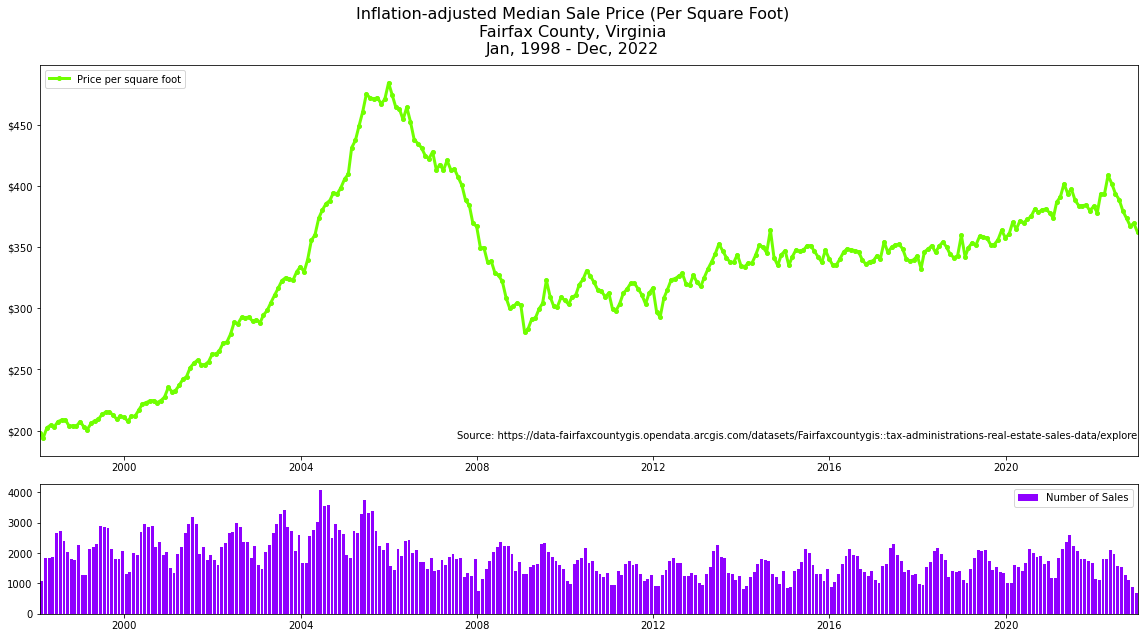

In [298]:
# graphing 
lookback = 12*25
fig, axs = plt.subplots(2, figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(inflation[-lookback:],
            linewidth=3, markersize=4, marker='o', color = '#70FF00',
            label='Price per square foot')
axs[1].bar(sales_monthly_count[-lookback:].index, 
           height=sales_monthly_count[-lookback:], 
           width=-24, color='#8F00FF', alpha=1, align='edge', edgecolor=None, linewidth=0, 
           label='Number of Sales')
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper right')
axs[0].yaxis.set_major_formatter('${x:1.0f}')
for ax in axs:
    ax.set_xlim([sales_monthly_count[-lookback:].index[0],sales_monthly_count[-lookback:].index[-1]])
fig.suptitle('Inflation-adjusted Median Sale Price (Per Square Foot)\nFairfax County, Virginia\n{} - {}'.format(
    sales_monthly_count[-lookback:].index[0].strftime('%b, %Y'),
    sales_monthly_count[-lookback:].index[-1].strftime('%b, %Y')),
             fontsize=16)
fig.tight_layout()
axs[0].text(inflation[-lookback:].index[-1], inflation.min(),'Source: https://data-fairfaxcountygis.opendata.arcgis.com/datasets/Fairfaxcountygis::tax-administrations-real-estate-sales-data/explore',
           horizontalalignment='right',)

In [44]:
owners = pd.read_csv('.\\fairfax\\Tax_Administration_s_Real_Estate_-_Property_Owner_Addresses.csv', 
                     usecols=['PARID', 'OWNER_FULL_NAME', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'CITY',
                               'STATE', 'COUNTRY', 'ZIP'])
legal = pd.read_csv('.\\fairfax\\Tax_Administration_s_Real_Estate_-_Legal_Data 112922.csv', 
                    usecols=['PARID', 'ADRNO', 'ADRADD', 'ADRDIR', 'ADRSTR', 'ADRSUF', 'ADRSUF2', 'CITYNAME', 'ZIP1', 'SQFT', 'LEGAL1', 'LEGAL2', 'LEGAL3', 'TAXDIST_DESC'])
owners = pd.merge(owners, legal)
owners

,PARID,OWNER_FULL_NAME,ADDRESS1,ADDRESS2,ADDRESS3,CITY,STATE,COUNTRY,ZIP,ADRNO,ADRADD,ADRDIR,ADRSTR,ADRSUF,ADRSUF2,CITYNAME,ZIP1,SQFT,LEGAL1,LEGAL2,LEGAL3,TAXDIST_DESC
0,0102 14 0231,MASLANKA BRIANAND MARGARET P,1449 POWELLS TAVERN PL,NaN,NaN,HERNDON,VA,US,201705727,1449.0,NaN,NaN,POWELLS TAVERN,PL,NaN,HERNDON,20170.0,9654.0,HASTINGS HUNT,LT 231 SEC 5,NaN,DRANESVILLE
1,0102 10 0022,PORTER REBECCA ANN,12520 BROWNS FERRY RD,NaN,NaN,HERNDON,VA,US,201705709,12520.0,NaN,NaN,BROWNS FERRY,RD,NaN,HERNDON,20170.0,10480.0,CRESTBROOK,LT 22 SEC 5,NaN,DRANESVILLE
2,0102 14 0266,CAPSALIS MANUEL ACAPSALIS CAROLE H,1483 POWELLS TAVERN PL,NaN,NaN,HERNDON,VA,US,201702882,1483.0,NaN,NaN,POWELLS TAVERN,PL,NaN,HERNDON,20170.0,9495.0,HASTINGS HUNT,LT 266 SEC 5,NaN,DRANESVILLE
3,0102 14 0111,DUPREE ANTHONY JRDUPREE DEBORAH M,12519 DARDANELLE CT,NaN,NaN,HERNDON,VA,US,201705735,12519.0,NaN,NaN,DARDANELLE,CT,NaN,HERNDON,20170.0,10180.0,HASTINGS HUNT,LT 111 SEC 3,NaN,DRANESVILLE
4,0102 06 0017,ARTE SHRUTI,1403 SKYHAVEN CT,NaN,NaN,HERNDON,VA,US,20170,1403.0,NaN,NaN,SKYHAVEN,CT,NaN,HERNDON,20170.0,13188.0,CRESTBROOK,LT 17 SEC 3,G1-31,DRANESVILLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366659,0314 35 0024,CHILHAM DEVELOPMENT COMPANY,1700 N ALBEMARLE ST,NaN,NaN,MCLEAN,VA,US,22101,1714.0,NaN,N,ALBERMARLE,ST,NaN,MCLEAN,22101.0,16742.0,DIGGES ADDITION TO CHESTERBROOK,LT 24,NaN,DRANESVILLE DIST. #1A11
366660,0314 35 0023,CHILHAM DEVELOPMENT COMPANY,1700 N ALBEMARLE ST,NaN,NaN,MCLEAN,VA,US,22101,6084.0,NaN,NaN,CHILHAM,WAY,NaN,MCLEAN,22101.0,16294.0,DIGGES ADDITION TO CHESTERBROOK,LT 23,NaN,DRANESVILLE DIST. #1A11
366661,0314 35 0022,CHILHAM DEVELOPMENT COMPANY,1700 N ALBEMARLE ST,NaN,NaN,MCLEAN,VA,US,22101,6086.0,NaN,NaN,CHILHAM,WAY,NaN,MCLEAN,22101.0,15102.0,DIGGES ADDITION TO CHESTERBROOK,LT 22,NaN,DRANESVILLE DIST. #1A11
366662,0314 35 0021,CHILHAM DEVELOPMENT COMPANY,1700 N ALBEMARLE ST,NaN,NaN,MCLEAN,VA,US,22101,6088.0,NaN,NaN,CHILHAM,WAY,NaN,MCLEAN,22101.0,20442.0,DIGGES ADDITION TO CHESTERBROOK,LT 21,NaN,DRANESVILLE DIST. #1A11


In [52]:
owners[owners['OWNER_FULL_NAME'].str.contains('BRAATEN')]

,PARID,OWNER_FULL_NAME,ADDRESS1,ADDRESS2,ADDRESS3,CITY,STATE,COUNTRY,ZIP,ADRNO,ADRADD,ADRDIR,ADRSTR,ADRSUF,ADRSUF2,CITYNAME,ZIP1,SQFT,LEGAL1,LEGAL2,LEGAL3,TAXDIST_DESC,APRTOT,PRITOT
211844,0652 09 0278,BRAATEN BRADLEY SBRAATEN MARY J,6359 LITTLEFIELD CT,NaN,NaN,CENTREVILLE,VA,US,20121,6359.0,NaN,NaN,LITTLEFIELD,CT,NaN,CENTREVILLE,20121.0,1500.0,HERITAGE ESTATES,LT 278 SEC 8,NaN,SULLY DIST. #2,411460,378120.0
262723,0592 08090009,BRAATEN SUSAN F TR,3319 EXECUTIVE AVE,NaN,NaN,FALLS CHURCH,VA,US,220423331,3319.0,NaN,NaN,EXECUTIVE,AVE,NaN,FALLS CHURCH,22042.0,10707.0,HOLMES RUN ACRES,LT 9 BLK 9 SEC 8,NaN,MASON DIST. #1,714900,600770.0
354774,0164 24080317,BRAATEN RYAN LAWRENCE,6 CIRRUS DR,APT 6209,NaN,ASHLAND,MA,US,017214424,12901.0,NaN,NaN,CENTRE PARK,CIR,NaN,HERNDON,20171.0,NaN,BRYSON AT WOODLAND PARK CONDO,UN 317 PH 8,PS446A,Hunter Mill Reston Service,202140,180480.0


In [46]:
owners['OWNER_FULL_NAME'].value_counts()[:20]

Name Withheld By Request                             7386
PARK AUTHORITY FAIRFAX COUNTY                        1946
BOARD OF SUPERVISORS FAIRFAX COUNTY                   691
REDEVELOPMENT AND HOUSING AUTHORITYFAIRFAX COUNTY     498
RESTON ASSOCIATION                                    347
SCHOOL BOARD OF FAIRFAX COUNTY                        258
VANTAGE RESIDENTIAL ACQUISITION LLC                   256
BURKE CENTRE CONSERVANCY                              237
JLV PARTNERS I LP                                     220
COMMONWEALTH OF VIRGINIA                              188
GP VA ASSOCIATES LLC                                  172
KINGSTOWNE RESIDENTIALOWNERS CORP                     157
ENCLAVE FL CORP                                       150
FRANKLIN FARM FOUNDATION                              108
BROOKFIELD HOLDINGS NORTH HILL LLC                    107
PARK AUTHORITY NORTHERNVIRGINIA REGIONAL               99
JLV PARTNERS II LP                                     99
AHC LIMITED PA

In [50]:
owners = pd.merge(owners,
         pd.read_csv('.\\Fairfax\\Tax_Administration_s_Real_Estate_-_Assessed_Values 112922.csv',
            usecols=['PARID', 'APRTOT', 'PRITOT']))